# Component 1: Project Proposal

## Introduction

In this project, I will be working on analyzing the sentiment(Positive/Negative) of the Amazon reviews dataset which contains reviews from various users for different Amazon products. The dataset contains two sentiments - Positive/Negative making this a binary classification task. The dataset is divided into a training set of size 1.59GB and a test set of size 176MB making this suitable for big data tasks.

Sentiment analysis is the process of classifying the sentiment of a text or speech as positive, negative or neutral. It has become an important field in driving various business decisions. Many studies have explored various approaches to sentiment analysis, such as rule-based methods, lexicon-based methods and machine learning methods. Rule-based methods involve simply classifying the text based on the presence of certain keywords whereas lexicon-based methods use dictionaries and their sentiment scores to classify text. The drawbacks of these methods are they fail to effectively capture the semantic relationship between the words and they will struggle to handle sarcasm in the reviews. For this project, we will be using machine learning methods to predict the sentiment of Amazon reviews.

I will be using HDFS - Hadoop Distributed File System for storing the dataset and pyspark on top of HDFS for processing the data and Spark's Mllib for analyzing and training the data with machine learning algorithms. Spark Mllib is designed to be distributed and can run on multiple large-scale computing clusters and it internally uses the power of Spark's distributed compute engine which allows it to process large datasets in parallel. So, in the future, for large datasets, as the data size increases we can horizontally scale the Hadoop Distributed File System's storage by adding more machines to the cluster and similarly to increase the processing power of Spark we can horizontally scale by adding more compute machines to the cluster without changing an pyspark code.

The dataset is imported by the spark from HDFS storage and various data exploration and visualization techniques are used in order to gain insights into the dataset .Then the dataset is pre-processed and relevant features were extracted for training the ML model using pyspark. After the feature extraction, the class imbalance is handled and the data is trained with 3 Machine learning models using pypspark MLlib on training data.All 3 models were evaluated against the validation data with the help of different performance metrics. The best model is selected based on the evaluation results of validation data and it is evaluated against the test set in order to measure the performance of our final model for predicting sentiments from a given review.

## Dataset

The dataset I am using for this project can be found at https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews

The dataset contains around 34 million Amazon reviews from 6 million Amazon users on 2 million products. It consists of the below columns

1.   **Title** - The review title
2.   **Review** - Users review on a particular product on Amazon
3.   **Polarity** - Which indicates the sentiment of users review. It has values 1, 2. 1 indicates Negative and 2 indicates Positive.

I will not load the dataset and analyze it with the help of data visualization and exploration techniques.



In [ ]:
# Importing all the essential libraries
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, VectorAssembler, Word2Vec, StandardScaler
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Creating a Spark Session
spark = SparkSession.builder.master("local[*]").appName("Amazon_Reviews_Sentiment_Analysis").getOrCreate()

In [ ]:
# Defining the path of the dataset which is stored on Hadoop Distributed File System
train_path = "hdfs:///user/hkhan012/course_work_2/train.csv"
test_path = "hdfs:///user/hkhan012/course_work_2/test.csv"

### Load Data

Loading the dataset

In [ ]:
amazon_reviews_df = spark.read.option("inferSchema", True).csv(train_path)

In [ ]:
amazon_reviews_df.show()

+---+--------------------+--------------------+
|_c0|                 _c1|                 _c2|
+---+--------------------+--------------------+
|  2|Stuning even for ...|This sound track ...|
|  2|The best soundtra...|I'm reading a lot...|
|  2|            Amazing!|"This soundtrack ...|
|  2|Excellent Soundtrack|I truly like this...|
|  2|Remember, Pull Yo...|If you've played ...|
|  2|an absolute maste...|I am quite sure a...|
|  1|        Buyer beware|"This is a self-p...|
|  2|      Glorious story|I loved Whisper o...|
|  2|    A FIVE STAR BOOK|I just finished r...|
|  2|Whispers of the W...|This was a easy t...|
|  1|          The Worst!|A complete waste ...|
|  2|          Great book|This was a great ...|
|  2|          Great Read|I thought this bo...|
|  1|           Oh please|I guess you have ...|
|  1|Awful beyond belief!|"I feel I have to...|
|  1|Don't try to fool...|It's glaringly ob...|
|  2|A romantic zen ba...|"When you hear fo...|
|  2|Fashionable Compr...|After I had a 

**Test Set**

Loading the test dataset

In [ ]:
amazon_reviews_df_test = spark.read.option("inferSchema", True).csv(test_path)

### Renaming Columns

In [ ]:
# Checking the column names and column types
amazon_reviews_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



Renaming the columns _c0, _c1, _c2 as Polarity, Title and Review

---



In [ ]:
amazon_reviews_df = amazon_reviews_df.withColumnRenamed('_c0', 'Polarity').withColumnRenamed('_c1', 'Title').withColumnRenamed('_c2', 'Review')
amazon_reviews_df.show()

+--------+--------------------+--------------------+
|Polarity|               Title|              Review|
+--------+--------------------+--------------------+
|       2|Stuning even for ...|This sound track ...|
|       2|The best soundtra...|I'm reading a lot...|
|       2|            Amazing!|"This soundtrack ...|
|       2|Excellent Soundtrack|I truly like this...|
|       2|Remember, Pull Yo...|If you've played ...|
|       2|an absolute maste...|I am quite sure a...|
|       1|        Buyer beware|"This is a self-p...|
|       2|      Glorious story|I loved Whisper o...|
|       2|    A FIVE STAR BOOK|I just finished r...|
|       2|Whispers of the W...|This was a easy t...|
|       1|          The Worst!|A complete waste ...|
|       2|          Great book|This was a great ...|
|       2|          Great Read|I thought this bo...|
|       1|           Oh please|I guess you have ...|
|       1|Awful beyond belief!|"I feel I have to...|
|       1|Don't try to fool...|It's glaringly 

Renaming the columns _c0, _c1, _c2 as Polarity, Title and Review in the Test Set


In [ ]:
amazon_reviews_df_test = amazon_reviews_df_test.withColumnRenamed('_c0', 'Polarity').withColumnRenamed('_c1', 'Title').withColumnRenamed('_c2', 'Review')

### Converting labels from {1, 2} to {0, 1}

Currently, the dataset has polarity with values 1 - which indicates Negative Sentiment and 2 - which indicates Postive Sentiment. Converting them to 1 - Positve Sentiment and 0 - Negative Sentiment for more meaningful representation

In [ ]:
amazon_reviews_df = amazon_reviews_df.withColumn('Polarity', when(amazon_reviews_df.Polarity==1, 0).otherwise(1))
amazon_reviews_df.show()

+--------+--------------------+--------------------+
|Polarity|               Title|              Review|
+--------+--------------------+--------------------+
|       1|Stuning even for ...|This sound track ...|
|       1|The best soundtra...|I'm reading a lot...|
|       1|            Amazing!|"This soundtrack ...|
|       1|Excellent Soundtrack|I truly like this...|
|       1|Remember, Pull Yo...|If you've played ...|
|       1|an absolute maste...|I am quite sure a...|
|       0|        Buyer beware|"This is a self-p...|
|       1|      Glorious story|I loved Whisper o...|
|       1|    A FIVE STAR BOOK|I just finished r...|
|       1|Whispers of the W...|This was a easy t...|
|       0|          The Worst!|A complete waste ...|
|       1|          Great book|This was a great ...|
|       1|          Great Read|I thought this bo...|
|       0|           Oh please|I guess you have ...|
|       0|Awful beyond belief!|"I feel I have to...|
|       0|Don't try to fool...|It's glaringly 

Converting for text set as well

In [ ]:
amazon_reviews_df_test = amazon_reviews_df_test.withColumn('Polarity', when(amazon_reviews_df_test.Polarity==1, 0).otherwise(1))
amazon_reviews_df_test.show()

+--------+--------------------+--------------------+
|Polarity|               Title|              Review|
+--------+--------------------+--------------------+
|       1|            Great CD|"My lovely Pat ha...|
|       1|One of the best g...|Despite the fact ...|
|       0|Batteries died wi...|I bought this cha...|
|       1|works fine, but M...|Check out Maha En...|
|       1|Great for the non...|Reviewed quite a ...|
|       0|DVD Player crappe...|I also began havi...|
|       0|      Incorrect Disc|I love the style ...|
|       0|DVD menu select p...|I cannot scroll t...|
|       1|Unique Weird Orie...|"Exotic tales of ...|
|       0|"Not an ""ultimat...|Firstly,I enjoyed...|
|       1|Great book for tr...|I currently live ...|
|       0|                Not!|If you want to li...|
|       0|     A complete Bust|"This game requir...|
|       1|TRULY MADE A DIFF...|I have been using...|
|       0|didn't run off of...|Was hoping that t...|
|       0|          Don't buy!|First of all, t

### Dropping Null Values

In [ ]:
# Delete null records
amazon_reviews_df = amazon_reviews_df.dropna(how='any')

### Data Visualisation

Checking number of reviews per each polarity

In [ ]:
# Get total count of user reviews per each polarity
amazon_reviews_count_per_polarity = amazon_reviews_df.groupBy("Polarity").agg(count("*").alias("Reviews_Per_Polarity"))
amazon_reviews_count_per_polarity.show()

+--------+--------------------+
|Polarity|Reviews_Per_Polarity|
+--------+--------------------+
|       1|             1799970|
|       0|             1799969|
+--------+--------------------+



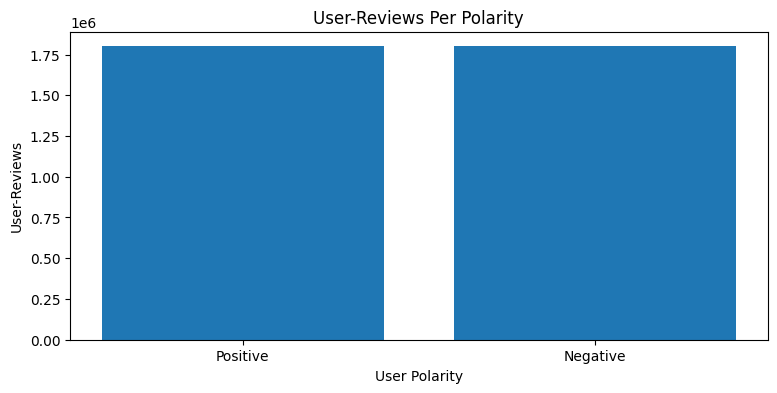

In [ ]:
# Plotting the results
polarity_sentiment = dict({1:'Positive', 0:'Negative'})
amazon_reviews_count_per_polarity_data = amazon_reviews_count_per_polarity.collect()
polarities = [polarity_sentiment[row["Polarity"]] for row in amazon_reviews_count_per_polarity_data]
reviews_count_per_polarity = [row["Reviews_Per_Polarity"] for row in amazon_reviews_count_per_polarity_data]

plt.figure(figsize=(9, 4))

plt.bar(polarities, reviews_count_per_polarity)
plt.xlabel("User Polarity")
plt.ylabel("User-Reviews")
plt.title("User-Reviews Per Polarity")

plt.show()

### Data Exploration

#### Total Count

In [ ]:
# Checking the total count of Amazon reviews
amazon_reviews_df.count()

3599939

#### Most Frequent Words in Title

Analyzing the top 100 most frequent words present in the Title Column

In [ ]:
# Getting the top 100 most frequent words from the Title column
title_rdd = amazon_reviews_df.rdd.map(lambda row: row.Title)
title_word_counts = title_rdd.flatMap(lambda title: title.split(" "))\
                             .filter(lambda word: len(word) > 3)\
                             .map(lambda word: (word.upper(), 1))\
                             .reduceByKey(lambda w1, w2: w1 + w2)
top_100_frequent_words_in_title = title_word_counts.sortBy(lambda record: -record[1]).take(100)
top_100_frequent_words_in_title

[('GREAT', 251169),
 ('THIS', 205179),
 ('GOOD', 177834),
 ('BOOK', 131029),
 ('VERY', 99145),
 ('BEST', 85128),
 ('WHAT', 74862),
 ('WITH', 69026),
 ("DON'T", 65282),
 ('YOUR', 57008),
 ('LOVE', 53830),
 ('EXCELLENT', 48455),
 ('READ', 47297),
 ('PRODUCT', 46449),
 ('MOVIE', 45450),
 ('HAVE', 44515),
 ('WASTE', 41591),
 ('LIKE', 41391),
 ('JUST', 40136),
 ('MONEY', 39911),
 ('FROM', 38623),
 ('POOR', 38008),
 ('WORK', 35141),
 ('WORTH', 34677),
 ('QUALITY', 34668),
 ('BETTER', 34148),
 ('EVER', 33850),
 ('TIME', 33002),
 ('THAT', 31382),
 ('NICE', 30872),
 ('THAN', 30421),
 ("IT'S", 30269),
 ('WORKS', 28789),
 ('MORE', 27664),
 ('DOES', 26961),
 ('WORST', 26109),
 ('REALLY', 25546),
 ('DISAPPOINTED', 24558),
 ('LITTLE', 24530),
 ('REVIEW', 24519),
 ('DISAPPOINTING', 24270),
 ('ONLY', 22986),
 ('MUST', 22788),
 ('ABOUT', 22644),
 ('MUCH', 22444),
 ('WELL', 21954),
 ("DOESN'T", 20900),
 ('PRICE', 20518),
 ('ALBUM', 20314),
 ('TERRIBLE', 20072),
 ('AWESOME', 19448),
 ('ANOTHER', 19295),


#### Most Frequent Words in Reviews

Analyzing the top 100 most frequent words present in the reviews column

In [ ]:
# Getting the top 100 most frequent words from the Reviews column
reviews_rdd = amazon_reviews_df.rdd.map(lambda row: row.Review)
reviews_word_counts = reviews_rdd.flatMap(lambda review: review.split(" "))\
                             .filter(lambda word: len(word) > 3)\
                             .map(lambda word: (word.lower(), 1))\
                             .reduceByKey(lambda w1, w2: w1 + w2)
top_100_frequent_words_in_reviews = reviews_word_counts.sortBy(lambda record: -record[1]).take(100)
top_100_frequent_words_in_reviews

[('this', 4330290),
 ('that', 2345438),
 ('with', 1760469),
 ('have', 1628407),
 ('book', 1221556),
 ('very', 870202),
 ('they', 868610),
 ('like', 835419),
 ('from', 788861),
 ('just', 786522),
 ('would', 732961),
 ('about', 695807),
 ('good', 625070),
 ('when', 613395),
 ('will', 603066),
 ('great', 594379),
 ('what', 568771),
 ('more', 562081),
 ("it's", 553141),
 ('only', 538189),
 ('your', 504208),
 ('some', 485481),
 ('really', 481014),
 ('there', 479336),
 ('read', 460868),
 ('than', 440860),
 ("don't", 422905),
 ('even', 419317),
 ('other', 419054),
 ('because', 406844),
 ('these', 406035),
 ('after', 401143),
 ('first', 399524),
 ('were', 390383),
 ('much', 385810),
 ('time', 377657),
 ('been', 370215),
 ('movie', 344399),
 ('bought', 343096),
 ('love', 341198),
 ('their', 335595),
 ('them', 330592),
 ('which', 321012),
 ('could', 307767),
 ('well', 292205),
 ('then', 285675),
 ('many', 284051),
 ('little', 283393),
 ('into', 280240),
 ('also', 280218),
 ('think', 270102),
 ('

#### Most Frequent Bigrams in Title

Analyzing the top 100 most frequent Bigrams(consecutive words of length 2) present in the Title.

In [ ]:
# Function which will return all the bigrams from a given review

def get_bigrams_words(review):
  bigram_words = []
  review_words = review.split()
  for i in range(0, len(review_words) - 1):
    bigram_words.append(review_words[i] + ' ' + review_words[i+1])
  return bigram_words

In [ ]:
# Getting the top 100 most frequent bigrams from Title column
title_bigrams_word_counts = title_rdd.flatMap(lambda title: get_bigrams_words(title))\
                             .map(lambda bigram: (bigram.upper(), 1))\
                             .reduceByKey(lambda b1, b2: b1 + b2)
top_100_frequent_bigrams_in_title = title_bigrams_word_counts.sortBy(lambda record: -record[1]).take(100)
top_100_frequent_bigrams_in_title

[('OF THE', 53049),
 ('THE BEST', 39890),
 ('FOR THE', 37595),
 ('THIS IS', 30289),
 ('A GREAT', 29398),
 ('THIS BOOK', 27864),
 ('ONE OF', 25728),
 ('IS A', 23583),
 ('A GOOD', 22006),
 ('DO NOT', 21931),
 ('WASTE OF', 21322),
 ('IN THE', 20780),
 ('NOT A', 19984),
 ('NOT WORTH', 18979),
 ('WHAT I', 18576),
 ('FOR A', 18219),
 ('IF YOU', 18070),
 ('WASTE YOUR', 17440),
 ('WHAT A', 15697),
 ('BUT NOT', 15620),
 ('BUY THIS', 15405),
 ('DOES NOT', 15121),
 ('NOT THE', 15011),
 ('TO THE', 14930),
 ('NOT WHAT', 14843),
 ("DON'T WASTE", 14656),
 ('WORTH THE', 14575),
 ('NOT FOR', 14573),
 ('YOUR MONEY', 14182),
 ('IS THE', 14164),
 ('VERY GOOD', 14125),
 ("DON'T BUY", 13997),
 ('GREAT FOR', 13868),
 ('TO BE', 12937),
 ('NOT AS', 12879),
 ('A MUST', 12849),
 ('ON THE', 12799),
 ('IS NOT', 12786),
 ('GREAT BOOK', 12505),
 ('OF A', 12105),
 ('NOT BUY', 11847),
 ('LOVE THIS', 11366),
 ('BETTER THAN', 11147),
 ('I LOVE', 11128),
 ('THE WORST', 11038),
 ('PIECE OF', 10679),
 ('I HAVE', 10541),
 (

#### Most Frequent Bigrams in Reviews

Analyzing the top 100 most frequent bigrams present in the Reviews column

In [ ]:
# Getting the top 100 most frequent bigrams present in the Reviews column
reviews_bigrams_word_counts = reviews_rdd.flatMap(lambda review: get_bigrams_words(review))\
                             .map(lambda bigram: (bigram.lower(), 1))\
                             .reduceByKey(lambda b1, b2: b1 + b2)
top_100_frequent_bigrams_in_reviews = reviews_bigrams_word_counts.sortBy(lambda record: -record[1]).take(100)
top_100_frequent_bigrams_in_reviews

[('of the', 1234037),
 ('in the', 735264),
 ('is a', 620650),
 ('this book', 572087),
 ('it is', 568506),
 ('this is', 527706),
 ('i have', 501409),
 ('and the', 478704),
 ('on the', 446458),
 ('i was', 425786),
 ('to the', 422900),
 ('it was', 420998),
 ('if you', 405274),
 ('to be', 379509),
 ('for the', 365228),
 ('and i', 350828),
 ('with the', 327293),
 ('for a', 295656),
 ('i am', 283553),
 ('is the', 278638),
 ('the book', 266464),
 ('one of', 262641),
 ('i would', 247842),
 ('and it', 230406),
 ('a great', 229580),
 ('is not', 226191),
 ('in a', 224771),
 ('that i', 221041),
 ('was a', 219275),
 ('i had', 212366),
 ('as a', 211373),
 ('book is', 206881),
 ('the first', 204384),
 ('but i', 203357),
 ('from the', 202665),
 ('i bought', 202579),
 ('a good', 194130),
 ('when i', 193328),
 ('to get', 191732),
 ('all the', 188434),
 ('with a', 188295),
 ('have to', 187207),
 ('of a', 179226),
 ('at the', 177140),
 ('of this', 172649),
 ('that the', 172462),
 ('the best', 167614),
 ('

## Planned implementation

The dataset is explored first by analyzing the top 100 most frequent words and bigrams present in the user reviews. Since the dataset contains words, we need to convert them to a suitable numerical format before training with a Machine learning model. I will be using the below pre-processing stages first inorder to convert the input suitable for training the ML model.

### Preprocessing

1.   **Combining the Title and Review Column** : The dataset contains two columns Title and Review and both these columns contribute to the users sentiment. Hence I will be concatinating both these columns to a single column User Opinions and use that final column for my further pre-processing

2.   **Tokenising the reviews** : The User opinions text is split into individual meaningful units such as words or tokens and it is a crucial step in coverting text to numerical format.
3.   **Removing the stop Words** : Once the text is converted to tokens, stop words removing is crucial in sentiment analysis which involves removing irrevelant words such as 'the', 'it', 'of', 'a', 'an' etc.., which do not convey much sentiment. Also removing the stop words reduces the total input dataset supplied to the ML model as input which decreases the computational complexity.
4.   **Converting the tokens to a numerical format** : There are several methods for converting the tokens into a numerical format such as TF-IDF vectors, Word2Vec etc.., TF-IDF involves calculating the Term Frequency of each word and multiplying with it Inverse Document Frequency(denotes the rarity of the word across all the reviews). Although this method is fast, it fails to capture the semantic relationship between the words. So I will be using Word2Vec for converting the tokens into Word Embeddings. In Word2Vec, first a neural network is trained on large amount of text data to predict the context of a word based on its surrrounding words and then the word embeddings are extracted from the weights learned during the training of the neural network. I will be first training the Word2Vec on my User Opinions text data and finally I will be transforming them using the trained Word2Vec model to generate the word embeddings.
5.   **Scaling the features and Assembling them**: I will be scaling all the features and assembling them to a single column using Vector Assembler.
6.   **Assigning class weights to handle the class imbalance** : During training the model, the ML models will might be biased towards the class with higher number of training samples while minimizing the loss function. Hence I will be assigning the class weights to address this issue.
7.   **Train, Validation Split**: Finally, I will be splitting the data into training and validation sets before training the ML models.
8.   **Sampling data for hyper parameter tuning**: To find out the optimal hyperparameters, I will be tuning the hyper parameters with a sample of data from the training set since it is computationally expensive for hyper tuning with the full dataset. After finding the optimal hyper parameters, I will be training the model with the full dataset using the optimal hyperparameters.

### Training with ML Models

I will be using the spark MLlib to train 3 ML models with the pre-processed data. Initially, I will be tuning the hyperparameters by training the model with different parameters on sampled training data and evaluating its performance against sampled validation data. Once, the optimal hyperparameters were found, I will be training the model with the training data and evaluate it's performace on validation data for all the 3 models and finally select one best model. I will be training the below ML models.

1.   **Random Forest Classifier** : Since the word embeddings were of high dimensions it can handle high dimensional data and extract relevant features to make accurate predictions. Since Random Forest uses multiple decision trees to predict the output it reduces overfitting and is robust to noise. I will be tuning the hyper parameters **maxDepth** - which indicates the maximum tree depth of the decision trees constructed by the Random Forest and **numTrees** - which indicates the total number of decision trees built by Random Forest Classifier.
2.   **Logistic Regression** : I will be using Logistic Regression since it can scale to large datasets efficiently and it will work very well for binary classification tasks. Unlike decision trees which will just classify as Positive or Negative, it will also provide probabilities of class category which indicates the degree of positivity and negativity. I will be tuning the hyper parameters **regParam** which controls the amount of regularization (a technique to prevent overfitting by adding a penality term to the loss function that depends on the coefficients of the model) and **elasticNetParam** which controls the balance between L1 and L2 regularization.
3.   **Support Vector Classifier** : I will be using Support Vector Classifier since it can handle high dimensionality very well and is a scalable algorithm just like Logistic Regression. It provides a flexible decision boundary which will seperate the sentiments of the reviews (Positive/Negative) and it can handle non linear relationships very well. I will be tuning the hyper parameters **regParam** which controls the amount of regularization and **maxIter** which controls the maximum number of iterations used by the optimization algorithm to find the optimal solution (which reduces loss function).

Then the best model will be trained with the full dataset(train + validation) and will be evaluated against the test set.

# Component 2: Implementation

Running the notebook for the full dataset takes a lot of time and also utilizes a lot of memory. Hence running the notebook for a sample data due to time and memory constraints.

In [ ]:
# Taking a fraction of data from the original dataset.
amazon_reviews_df = amazon_reviews_df.sampleBy('Polarity', fractions = {0:0.10, 1:0.10}).cache()
amazon_reviews_df_test = amazon_reviews_df_test.sampleBy('Polarity', fractions = {0:0.10, 1:0.10}).cache()

## Data Preprocessing

In [ ]:
amazon_reviews_df.show()

+--------+--------------------+--------------------+
|Polarity|               Title|              Review|
+--------+--------------------+--------------------+
|       1|The best soundtra...|I'm reading a lot...|
|       1|    A FIVE STAR BOOK|I just finished r...|
|       0|sizes recomended ...|sizes are much sm...|
|       0|        Mind numbing|This game makes y...|
|       0|      *** BEWARE ***|"This TV is set s...|
|       1|     Homer or Moses?|An extremely help...|
|       0|  Very poor quality.|"The screen arriv...|
|       1|              YES!!!|When I got this b...|
|       0|Too Uncomfortable...|These pants were ...|
|       0|     I got fooled...|I did not know th...|
|       0|Excellent book, v...|Yet another examp...|
|       1|I found it! Henry...|"I had two Henry ...|
|       1|A Contemporary Fa...|While this book i...|
|       0|Not professional ...|I first tried buy...|
|       0|     Great for Twins|I purchased the A...|
|       1|They're blocks - ...|"We got these a

In [ ]:
# Initially I will be performing operations on the preprocess dataframe, later I will create a pipeline to automate the pre-processing steps for the original dataframe.
amazon_reviews_df_to_preprocess = amazon_reviews_df

Concatinating Title and Review into one column - User_Opinion

In [ ]:
amazon_reviews_df_to_preprocess = amazon_reviews_df_to_preprocess.withColumn("User_Opinion", concat(col("Title"), lit(" . "), col("Review")))
amazon_reviews_df_to_preprocess = amazon_reviews_df_to_preprocess.select('Polarity', 'User_Opinion')
amazon_reviews_df_to_preprocess.show()

+--------+--------------------+
|Polarity|        User_Opinion|
+--------+--------------------+
|       1|The best soundtra...|
|       1|A FIVE STAR BOOK ...|
|       0|sizes recomended ...|
|       0|Mind numbing . Th...|
|       0|*** BEWARE *** . ...|
|       1|Homer or Moses? ....|
|       0|Very poor quality...|
|       1|YES!!! . When I g...|
|       0|Too Uncomfortable...|
|       0|I got fooled... ....|
|       0|Excellent book, v...|
|       1|I found it! Henry...|
|       1|A Contemporary Fa...|
|       0|Not professional ...|
|       0|Great for Twins ....|
|       1|They're blocks - ...|
|       0|It's a knock off....|
|       1|NOT the worst Ame...|
|       0|Unmasked............|
|       0|If it ain't broke...|
+--------+--------------------+
only showing top 20 rows



Splitting the column - User_Opinion into multiple tokens - User_Opinion_Tokens (individual words/ smaller units)

In [ ]:
amazon_reviews_tokenizer = Tokenizer(inputCol='User_Opinion', outputCol='User_Opinion_Tokens')
amazon_reviews_df_to_preprocess = amazon_reviews_tokenizer.transform(amazon_reviews_df_to_preprocess).select('Polarity', 'User_Opinion_Tokens')
amazon_reviews_df_to_preprocess.show()

+--------+--------------------+
|Polarity| User_Opinion_Tokens|
+--------+--------------------+
|       1|[the, best, sound...|
|       1|[a, five, star, b...|
|       0|[sizes, recomende...|
|       0|[mind, numbing, ....|
|       0|[***, beware, ***...|
|       1|[homer, or, moses...|
|       0|[very, poor, qual...|
|       1|[yes!!!, ., when,...|
|       0|[too, uncomfortab...|
|       0|[i, got, fooled.....|
|       0|[excellent, book,...|
|       1|[i, found, it!, h...|
|       1|[a, contemporary,...|
|       0|[not, professiona...|
|       0|[great, for, twin...|
|       1|[they're, blocks,...|
|       0|[it's, a, knock, ...|
|       1|[not, the, worst,...|
|       0|[unmasked...........|
|       0|[if, it, ain't, b...|
+--------+--------------------+
only showing top 20 rows



Removing the stop words from the User_Opinion_Tokens column

In [ ]:
amazon_reviews_stop_words_remover = StopWordsRemover(inputCol='User_Opinion_Tokens', outputCol='User_Opinion_Filterd_Tokens')
amazon_reviews_df_to_preprocess = amazon_reviews_stop_words_remover.transform(amazon_reviews_df_to_preprocess).select('Polarity', 'User_Opinion_Filterd_Tokens')
amazon_reviews_df_to_preprocess.show()

+--------+---------------------------+
|Polarity|User_Opinion_Filterd_Tokens|
+--------+---------------------------+
|       1|       [best, soundtrack...|
|       1|       [five, star, book...|
|       0|       [sizes, recomende...|
|       0|       [mind, numbing, ....|
|       0|       [***, beware, ***...|
|       1|       [homer, moses?, ....|
|       0|       [poor, quality., ...|
|       1|       [yes!!!, ., got, ...|
|       0|       [uncomfortable, b...|
|       0|       [got, fooled..., ...|
|       0|       [excellent, book,...|
|       1|       [found, it!, henr...|
|       1|       [contemporary, fa...|
|       0|       [professional, qu...|
|       0|       [great, twins, .,...|
|       1|       [blocks, -, keep,...|
|       0|       [knock, off., ., ...|
|       1|       [worst, american,...|
|       0|       [unmasked...........|
|       0|       [ain't, broke, fi...|
+--------+---------------------------+
only showing top 20 rows



Training the final tokens with Word2Vec model

In [ ]:
amazon_reviews_word_to_vec = Word2Vec(inputCol='User_Opinion_Filterd_Tokens', outputCol='User_Opinion_Word_Embeddings')
amazon_reviews_word_to_vec = amazon_reviews_word_to_vec.fit(amazon_reviews_df_to_preprocess)

After training the model, we will test it (whether it has learnt the features between words correctly or not) by finding some similar words to a particular word

In [ ]:
amazon_reviews_word_to_vec.findSynonyms("amazing", 5).show()

+-----------+------------------+
|       word|        similarity|
+-----------+------------------+
| incredible|0.8460341691970825|
|  fantastic|0.7821407914161682|
|    awesome|0.7093379497528076|
|outstanding|0.6820644736289978|
|  wonderful|0.6775855422019958|
+-----------+------------------+



In [ ]:
amazon_reviews_word_to_vec.findSynonyms("great", 5).show()

+---------+------------------+
|     word|        similarity|
+---------+------------------+
| terrific|0.7913282513618469|
|excellent| 0.765444278717041|
|fantastic|0.7629461884498596|
|  awesome|  0.76242595911026|
|     good|0.6973778009414673|
+---------+------------------+



In [ ]:
amazon_reviews_word_to_vec.findSynonyms("story", 5).show()

+---------+------------------+
|     word|        similarity|
+---------+------------------+
|   story,|0.8585571646690369|
|   story.|0.8069674372673035|
|     plot|0.7243809700012207|
|    tale,|0.7231417298316956|
|storyline|0.7001497745513916|
+---------+------------------+



Finally transforming the user review tokens into word embedding vectors with Word2Vec model

In [ ]:
amazon_reviews_df_to_preprocess = amazon_reviews_word_to_vec.transform(amazon_reviews_df_to_preprocess)
amazon_reviews_df_to_preprocess = amazon_reviews_df_to_preprocess.select('Polarity', 'User_Opinion_Word_Embeddings')
amazon_reviews_df_to_preprocess.show()

+--------+----------------------------+
|Polarity|User_Opinion_Word_Embeddings|
+--------+----------------------------+
|       1|        [-0.0358363226380...|
|       1|        [-0.0920378355532...|
|       0|        [0.03176117469759...|
|       0|        [-0.0582564079086...|
|       0|        [-0.0273337300002...|
|       1|        [-0.0015187422267...|
|       0|        [-0.0535063293161...|
|       1|        [-0.0632975047119...|
|       0|        [0.05508926662150...|
|       0|        [-0.0164264570066...|
|       0|        [-0.0396259729439...|
|       1|        [-0.0212134202192...|
|       1|        [-0.0262760660041...|
|       0|        [-0.0211847637517...|
|       0|        [-0.1222132123740...|
|       1|        [0.00297363132458...|
|       0|        [-0.0997172124151...|
|       1|        [-0.0332171532791...|
|       0|        [-0.0218392734628...|
|       0|        [-0.0395442961094...|
+--------+----------------------------+
only showing top 20 rows



Scaling the Word Embeddings

In [ ]:
amazon_reviews_scaler = StandardScaler(inputCol='User_Opinion_Word_Embeddings', outputCol='Scaled_User_Opinions')
amazon_reviews_df_to_preprocess = amazon_reviews_scaler.fit(amazon_reviews_df_to_preprocess).transform(amazon_reviews_df_to_preprocess)
amazon_reviews_df_to_preprocess = amazon_reviews_df_to_preprocess.select('Polarity', 'Scaled_User_Opinions')
amazon_reviews_df_to_preprocess.show()

+--------+--------------------+
|Polarity|Scaled_User_Opinions|
+--------+--------------------+
|       1|[-0.7857775537532...|
|       1|[-2.0180995132866...|
|       0|[0.69642240947274...|
|       0|[-1.2773793270949...|
|       0|[-0.5993425081995...|
|       1|[-0.0333012280251...|
|       0|[-1.1732250818540...|
|       1|[-1.3879146840389...|
|       0|[1.20793390552859...|
|       0|[-0.3601804050582...|
|       0|[-0.8688726351608...|
|       1|[-0.4651434137098...|
|       1|[-0.5761512718681...|
|       0|[-0.4645150677380...|
|       0|[-2.6797503757758...|
|       1|[0.06520235827774...|
|       0|[-2.1864840326999...|
|       1|[-0.7283474286679...|
|       0|[-0.4788664018544...|
|       0|[-0.8670817197299...|
+--------+--------------------+
only showing top 20 rows



Using Vector Assembler to assemble all features. In our case, since Word2Vec already assembles the learnt features in one vector this step is not required but only adding it to generalize the code for various datasets.

In [ ]:
amazon_reviews_vector_assembler = VectorAssembler(inputCols=['Scaled_User_Opinions'], outputCol='Final_User_Opinions')
amazon_reviews_df_to_preprocess = amazon_reviews_vector_assembler.transform(amazon_reviews_df_to_preprocess)
amazon_reviews_df_to_preprocess = amazon_reviews_df_to_preprocess.select('Polarity', 'Final_User_Opinions')
amazon_reviews_df_to_preprocess.show()

+--------+--------------------+
|Polarity| Final_User_Opinions|
+--------+--------------------+
|       1|[-0.7857775537532...|
|       1|[-2.0180995132866...|
|       0|[0.69642240947274...|
|       0|[-1.2773793270949...|
|       0|[-0.5993425081995...|
|       1|[-0.0333012280251...|
|       0|[-1.1732250818540...|
|       1|[-1.3879146840389...|
|       0|[1.20793390552859...|
|       0|[-0.3601804050582...|
|       0|[-0.8688726351608...|
|       1|[-0.4651434137098...|
|       1|[-0.5761512718681...|
|       0|[-0.4645150677380...|
|       0|[-2.6797503757758...|
|       1|[0.06520235827774...|
|       0|[-2.1864840326999...|
|       1|[-0.7283474286679...|
|       0|[-0.4788664018544...|
|       0|[-0.8670817197299...|
+--------+--------------------+
only showing top 20 rows



### Creating a Pipeline to automatically pre-process the data

I will be creating a pipeline, to automate all the above pre-processing steps and to make the pre-processing steps consistent across training and testing sets. It will have the following stages

1.   Replacing null reviews with empty string - ''
2.   Concatination of Title and Reviews column
3.   Tokenising Reviews
4.   Stop words Removal
5.   Converting tokens to Word Embeddings using Word2Vec
6.   Scaling
7.   Vector Assembling







In [ ]:
# Creating a class to replace null values with empty string ''. I have implemented the transform method from the Transformer class to use with the pipeline
class AmazonReviewsNullHandler(Transformer, HasInputCol, HasOutputCol):

  def __init__(self):
    super(AmazonReviewsNullHandler, self).__init__()

  def _transform(self, amazon_reviews_df):
    return amazon_reviews_df.na.fill('')

In [ ]:
# Creating a class to concatinate two columns. I have implemented the transform method from the Transformer class to use with the pipeline
class AmazonReviewMerger(Transformer, HasInputCol, HasOutputCol):

    def __init__(self, inputCol1=None, inputCol2=None, outputCol=None):
        super(AmazonReviewMerger, self).__init__()
        self.inputCol1 = inputCol1
        self.inputCol2 = inputCol2
        self.outputCol = outputCol

    def _transform(self, amazon_reviews_df):
        return amazon_reviews_df.withColumn(self.outputCol, concat(col(self.inputCol1), lit(" . "), col(self.inputCol2)))

Defining all the stages in the Pipeline

In [ ]:
amazon_reviews_null_handler = AmazonReviewsNullHandler()
amazon_reviews_merger = AmazonReviewMerger(inputCol1='Title', inputCol2='Review', outputCol='User_Opinion')
amazon_reviews_tokenizer = Tokenizer(inputCol='User_Opinion', outputCol='User_Opinion_Tokens')
amazon_reviews_stop_words_remover = StopWordsRemover(inputCol='User_Opinion_Tokens', outputCol='User_Opinion_Filterd_Tokens')
amazon_reviews_word_to_vec = Word2Vec(inputCol='User_Opinion_Filterd_Tokens', outputCol='User_Opinion_Word_Embeddings')
amazon_reviews_scaler = StandardScaler(inputCol='User_Opinion_Word_Embeddings', outputCol='Scaled_User_Opinions')
amazon_reviews_vector_assembler = VectorAssembler(inputCols=['Scaled_User_Opinions'], outputCol='Final_User_Opinions')

In [ ]:
pipeline_stages = [amazon_reviews_null_handler, amazon_reviews_merger, amazon_reviews_tokenizer, amazon_reviews_stop_words_remover, amazon_reviews_word_to_vec, amazon_reviews_scaler, amazon_reviews_vector_assembler]

Creating the Pipeline and fitting it on the dataset.

In [ ]:
amazon_reviews_pipeline = Pipeline(stages=pipeline_stages)
amazon_reviews_pipeline = amazon_reviews_pipeline.fit(amazon_reviews_df)
amazon_reviews_df = amazon_reviews_pipeline.transform(amazon_reviews_df)
amazon_reviews_df.show()

+--------+--------------------+--------------------+--------------------+--------------------+---------------------------+----------------------------+--------------------+--------------------+
|Polarity|               Title|              Review|        User_Opinion| User_Opinion_Tokens|User_Opinion_Filterd_Tokens|User_Opinion_Word_Embeddings|Scaled_User_Opinions| Final_User_Opinions|
+--------+--------------------+--------------------+--------------------+--------------------+---------------------------+----------------------------+--------------------+--------------------+
|       1|The best soundtra...|I'm reading a lot...|The best soundtra...|[the, best, sound...|       [best, soundtrack...|        [-0.0358363226380...|[-0.7857775537532...|[-0.7857775537532...|
|       1|    A FIVE STAR BOOK|I just finished r...|A FIVE STAR BOOK ...|[a, five, star, b...|       [five, star, book...|        [-0.0920378355532...|[-2.0180995132866...|[-2.0180995132866...|
|       0|sizes recomended ...

In [ ]:
amazon_reviews_df = amazon_reviews_df.select('Polarity', 'Final_User_Opinions')
amazon_reviews_df.show()

+--------+--------------------+
|Polarity| Final_User_Opinions|
+--------+--------------------+
|       1|[-0.7857775537532...|
|       1|[-2.0180995132866...|
|       0|[0.69642240947274...|
|       0|[-1.2773793270949...|
|       0|[-0.5993425081995...|
|       1|[-0.0333012280251...|
|       0|[-1.1732250818540...|
|       1|[-1.3879146840389...|
|       0|[1.20793390552859...|
|       0|[-0.3601804050582...|
|       0|[-0.8688726351608...|
|       1|[-0.4651434137098...|
|       1|[-0.5761512718681...|
|       0|[-0.4645150677380...|
|       0|[-2.6797503757758...|
|       1|[0.06520235827774...|
|       0|[-2.1864840326999...|
|       1|[-0.7283474286679...|
|       0|[-0.4788664018544...|
|       0|[-0.8670817197299...|
+--------+--------------------+
only showing top 20 rows



### Handling class imbalance

In [ ]:
class_count = amazon_reviews_df.groupBy("Polarity").agg(count("*").alias("Reviews_Per_Polarity"))
class_count.show()

+--------+--------------------+
|Polarity|Reviews_Per_Polarity|
+--------+--------------------+
|       1|              180078|
|       0|              180948|
+--------+--------------------+



**Since the dataset is imbalanced, while training ml model - the model will be biased towards the majority class. Hence, class weights is used to handle class imbalance. Although in this case, the difference is very small, still using class weights to handle this imbalance in order to generalize for future datasets**

In [ ]:
class_count = class_count.rdd.collectAsMap()
class_count

{1: 180078, 0: 180948}

In [ ]:
polarity_0_balancing_ratio = class_count[1]/(class_count[0] + class_count[1])
polarity_0_balancing_ratio

0.49879510062987154

In [ ]:
amazon_reviews_df = amazon_reviews_df.withColumn('polarityClassWeights', when(amazon_reviews_df.Polarity == 0, polarity_0_balancing_ratio).otherwise(1-polarity_0_balancing_ratio))
amazon_reviews_df.show()

+--------+--------------------+--------------------+
|Polarity| Final_User_Opinions|polarityClassWeights|
+--------+--------------------+--------------------+
|       1|[-0.7857775537532...|  0.5012048993701285|
|       1|[-2.0180995132866...|  0.5012048993701285|
|       0|[0.69642240947274...| 0.49879510062987154|
|       0|[-1.2773793270949...| 0.49879510062987154|
|       0|[-0.5993425081995...| 0.49879510062987154|
|       1|[-0.0333012280251...|  0.5012048993701285|
|       0|[-1.1732250818540...| 0.49879510062987154|
|       1|[-1.3879146840389...|  0.5012048993701285|
|       0|[1.20793390552859...| 0.49879510062987154|
|       0|[-0.3601804050582...| 0.49879510062987154|
|       0|[-0.8688726351608...| 0.49879510062987154|
|       1|[-0.4651434137098...|  0.5012048993701285|
|       1|[-0.5761512718681...|  0.5012048993701285|
|       0|[-0.4645150677380...| 0.49879510062987154|
|       0|[-2.6797503757758...| 0.49879510062987154|
|       1|[0.06520235827774...|  0.50120489937

### Splitting the data into Training Set and Validation Set

In [ ]:
# 90% of data is taken as Training Set and 10% as validation set
amazon_reviews_df_train = amazon_reviews_df.sampleBy('Polarity', fractions = {0:0.90, 1:0.90})
amazon_reviews_df_val = amazon_reviews_df.subtract(amazon_reviews_df_train)

### Sampling Data for Hyper Parameter Tuning

Taking a sample of data for tuning the hyper parameters.

In [ ]:
amazon_reviews_df_train_sampled = amazon_reviews_df_train.sampleBy('Polarity', fractions = {0:0.10, 1:0.10}).cache()
amazon_reviews_df_val_sampled = amazon_reviews_df_val.sampleBy('Polarity', fractions = {0:0.10, 1:0.10}).cache()

## Random Forest Classifier

### Hyper Parameter Tuning On Sampled Data

In [ ]:
amazon_reviews_rf_tuning_data = pd.DataFrame(columns=['numTrees', 'maxDepth', 'Accuracy'])
amazon_reviews_rf_tuning_data

,numTrees,maxDepth,Accuracy


In [ ]:
# Training the Random Forest model with different hyper parameters and storing the hyper parameters and Accuracy in a Pandas Dataframe.
num_of_trees = [10, 20, 30]
max_depth = [5, 7, 10]

for trees in num_of_trees:
  for depth in max_depth:
    amazon_reviews_rf_classifier = RandomForestClassifier(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights', numTrees=trees, maxDepth=depth)
    amazon_reviews_rf_classifier = amazon_reviews_rf_classifier.fit(amazon_reviews_df_train_sampled)
    amazon_reviews_df_val_sampled_predictions = amazon_reviews_rf_classifier.transform(amazon_reviews_df_val_sampled)
    accuracy = amazon_reviews_df_val_sampled_predictions.withColumn("correct_prediction", when(col("Polarity") == col("prediction"), 1).otherwise(0)).select(avg(col("correct_prediction"))).collect()[0][0]
    amazon_reviews_rf_tuning_data = pd.concat([amazon_reviews_rf_tuning_data, pd.DataFrame({
        'numTrees': [trees],
        'maxDepth': [depth],
        'Accuracy': [accuracy * 100]
    })])
    print(trees, depth)

10 5
10 7
10 10
20 5
20 7
20 10
30 5
30 7
30 10


Results of hyper parameter tuning

In [ ]:
amazon_reviews_rf_tuning_data

,numTrees,maxDepth,Accuracy
0,10,5,75.492958
0,10,7,78.253521
0,10,10,78.563380
0,20,5,75.746479
0,20,7,78.366197
0,20,10,79.633803
0,30,5,77.239437
0,30,7,78.309859
0,30,10,79.718310


From the above table, we observe that the accuracy is highest when the **maxDepth** is 10 and **numTrees** is 30. Using the above parameters to train the model on full training set.

### Training the model with best hyper parameters on Training Data

In [ ]:
amazon_reviews_best_rf_model = RandomForestClassifier(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights', maxDepth=10, numTrees=30)
amazon_reviews_best_rf_model = amazon_reviews_best_rf_model.fit(amazon_reviews_df_train)

### Evaluating on Validation Set

In [ ]:
amazon_reviews_df_val_predictions = amazon_reviews_best_rf_model.transform(amazon_reviews_df_val)

#### Confusion Matrix

In [ ]:
true_postives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 1) & (col("prediction") == 1)).count()
false_postives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 0) & (col("prediction") == 1)).count()
true_negatives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 0) & (col("prediction") == 0)).count()
false_negatives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 1) & (col("prediction") == 0)).count()

amazon_reviews_confusion_matrix = spark.createDataFrame([('Prediction - Positive', true_postives, false_postives), ('Prediction - Negative', false_negatives, true_negatives)], ['', 'Actual - Positive', 'Actual - Negative'])
amazon_reviews_confusion_matrix.show(truncate=False)

+---------------------+-----------------+-----------------+
|                     |Actual - Positive|Actual - Negative|
+---------------------+-----------------+-----------------+
|Prediction - Positive|14214            |3173             |
|Prediction - Negative|3826             |14695            |
+---------------------+-----------------+-----------------+



#### Accuracy

In [ ]:
accuracy = ((true_postives + true_negatives)/(true_postives + true_negatives + false_postives + false_negatives)) * 100
print('Accuracy : ', accuracy)

Accuracy :  80.5085217778768


#### Precision

In [ ]:
precision = true_postives / (true_postives + false_postives)
print('Precision : ', precision)

Precision :  0.8175073330649336


#### Recall

In [ ]:
recall = true_postives / (true_postives + false_negatives)
print('Recall : ', recall)

Recall :  0.7879157427937916


## Logistic Regression

### Hyper Parameter Tuning On Sampled Data

In [ ]:
amazon_reviews_lr_tuning_data = pd.DataFrame(columns=['regParam', 'elasticNetParam', 'Accuracy'])
amazon_reviews_lr_tuning_data

,regParam,elasticNetParam,Accuracy


In [ ]:
# Training the Logistic Regression model with different hyper parameters and storing the hyper parameters and Accuracy in a Pandas Dataframe.
reg_params = [0.01, 0.1, 1.0]
elastic_net_params = [0.0, 0.5, 1.0]

for reg_param in reg_params:
  for elastic_net_param in elastic_net_params:
    amazon_reviews_lr_classifier = LogisticRegression(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights', regParam=reg_param, elasticNetParam=elastic_net_param)
    amazon_reviews_lr_classifier = amazon_reviews_lr_classifier.fit(amazon_reviews_df_train_sampled)
    amazon_reviews_df_val_sampled_predictions = amazon_reviews_lr_classifier.transform(amazon_reviews_df_val_sampled)
    accuracy = amazon_reviews_df_val_sampled_predictions.withColumn("correct_prediction", when(col("Polarity") == col("prediction"), 1).otherwise(0)).select(avg(col("correct_prediction"))).collect()[0][0]
    amazon_reviews_lr_tuning_data = pd.concat([amazon_reviews_lr_tuning_data, pd.DataFrame({
        'regParam': [reg_param],
        'elasticNetParam': [elastic_net_param],
        'Accuracy': [accuracy * 100]
    })])
    print(reg_param, elastic_net_param)

0.01 0.0
0.01 0.5
0.01 1.0
0.1 0.0
0.1 0.5
0.1 1.0
1.0 0.0
1.0 0.5
1.0 1.0


Results of hyper parameter tuning

In [ ]:
amazon_reviews_lr_tuning_data

,regParam,elasticNetParam,Accuracy
0,0.01,0.0,84.394366
0,0.01,0.5,83.549296
0,0.01,1.0,82.985915
0,0.10,0.0,83.605634
0,0.10,0.5,77.267606
0,0.10,1.0,74.647887
0,1.00,0.0,80.760563
0,1.00,0.5,50.535211
0,1.00,1.0,50.535211


From the above table, we observe that the optimal hyper parameters were **regParam=0.01** and **elasticNetParam=0.0**

### Training the model with best hyper parameters on Training Data

In [ ]:
amazon_reviews_best_lr_model = LogisticRegression(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights',
                                                      regParam=0.01, elasticNetParam=0.0)
amazon_reviews_best_lr_model = amazon_reviews_best_lr_model.fit(amazon_reviews_df_train)

### Evaluating on Validation Set

In [ ]:
amazon_reviews_df_val_predictions = amazon_reviews_best_lr_model.transform(amazon_reviews_df_val)

#### Confusion Matrix

In [ ]:
true_postives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 1) & (col("prediction") == 1)).count()
false_postives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 0) & (col("prediction") == 1)).count()
true_negatives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 0) & (col("prediction") == 0)).count()
false_negatives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 1) & (col("prediction") == 0)).count()

amazon_reviews_confusion_matrix = spark.createDataFrame([('Prediction - Positive', true_postives, false_postives), ('Prediction - Negative', false_negatives, true_negatives)], ['', 'Actual - Positive', 'Actual - Negative'])
amazon_reviews_confusion_matrix.show(truncate=False)

+---------------------+-----------------+-----------------+
|                     |Actual - Positive|Actual - Negative|
+---------------------+-----------------+-----------------+
|Prediction - Positive|15293            |2646             |
|Prediction - Negative|2747             |15222            |
+---------------------+-----------------+-----------------+



#### Accuracy

In [ ]:
accuracy = ((true_postives + true_negatives)/(true_postives + true_negatives + false_postives + false_negatives)) * 100
print('Accuracy : ', accuracy)

Accuracy :  84.98106271582934


#### Precision

In [ ]:
precision = true_postives / (true_postives + false_postives)
print('Precision : ', precision)

Precision :  0.8525001393611684


#### Recall

In [ ]:
recall = true_postives / (true_postives + false_negatives)
print('Recall : ', recall)

Recall :  0.8477272727272728


## Support Vector Classifier

### Hyper Parameter Tuning On Sampled Data

In [ ]:
amazon_reviews_svc_tuning_data = pd.DataFrame(columns=['regParam', 'maxIter', 'Accuracy'])
amazon_reviews_svc_tuning_data

,regParam,maxIter,Accuracy


In [ ]:
# Training the Support Vector Classifier with different hyper parameters and storing the hyper parameters and Accuracy in a Pandas Dataframe.
reg_params =  [0.01, 0.1, 1]
max_iters = [5, 10, 20]

for reg_param in reg_params:
  for max_iter in max_iters:
    amazon_reviews_svc_classifier = LinearSVC(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights', regParam=reg_param, maxIter=max_iter)
    amazon_reviews_svc_classifier = amazon_reviews_svc_classifier.fit(amazon_reviews_df_train_sampled)
    amazon_reviews_df_val_sampled_predictions = amazon_reviews_svc_classifier.transform(amazon_reviews_df_val_sampled)
    accuracy = amazon_reviews_df_val_sampled_predictions.withColumn("correct_prediction", when(col("Polarity") == col("prediction"), 1).otherwise(0)).select(avg(col("correct_prediction"))).collect()[0][0]
    amazon_reviews_svc_tuning_data = pd.concat([amazon_reviews_svc_tuning_data, pd.DataFrame({
          'regParam': [reg_param],
          'maxIter': [max_iter],
          'Accuracy': [accuracy * 100]
      })])
    print(reg_param, max_iter)

0.01 5
0.01 10
0.01 20
0.1 5
0.1 10
0.1 20
1 5
1 10
1 20


Results of hyper parameter tuning

In [ ]:
amazon_reviews_svc_tuning_data

,regParam,maxIter,Accuracy
0,0.01,5,82.450704
0,0.01,10,84.394366
0,0.01,20,84.309859
0,0.10,5,82.366197
0,0.10,10,84.140845
0,0.10,20,84.366197
0,1.00,5,81.295775
0,1.00,10,81.971831
0,1.00,20,81.971831


From the above table, we observe that the optimal hyper parameters were **regParam**=0.01, **maxIter**=10

### Training the model with best hyper parameters on Training Data

In [ ]:
amazon_reviews_best_svc_model = LinearSVC(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights',
                                                      regParam=0.01, maxIter=10)
amazon_reviews_best_svc_model = amazon_reviews_best_svc_model.fit(amazon_reviews_df_train)

### Evaluation on Validation Set

In [ ]:
amazon_reviews_df_val_predictions = amazon_reviews_best_svc_model.transform(amazon_reviews_df_val)

#### Confusion Matrix

In [ ]:
true_postives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 1) & (col("prediction") == 1)).count()
false_postives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 0) & (col("prediction") == 1)).count()
true_negatives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 0) & (col("prediction") == 0)).count()
false_negatives = amazon_reviews_df_val_predictions.filter((col("Polarity") == 1) & (col("prediction") == 0)).count()

amazon_reviews_confusion_matrix = spark.createDataFrame([('Prediction - Positive', true_postives, false_postives), ('Prediction - Negative', false_negatives, true_negatives)], ['', 'Actual - Positive', 'Actual - Negative'])
amazon_reviews_confusion_matrix.show(truncate=False)

+---------------------+-----------------+-----------------+
|                     |Actual - Positive|Actual - Negative|
+---------------------+-----------------+-----------------+
|Prediction - Positive|15284            |2680             |
|Prediction - Negative|2756             |15188            |
+---------------------+-----------------+-----------------+



#### Accuracy

In [ ]:
accuracy = ((true_postives + true_negatives)/(true_postives + true_negatives + false_postives + false_negatives)) * 100
print('Accuracy : ', accuracy)

Accuracy :  84.86131224239723


#### Precision

In [ ]:
precision = true_postives / (true_postives + false_postives)
print('Precision : ', precision)

Precision :  0.8508127365842797


#### Recall

In [ ]:
recall = true_postives / (true_postives + false_negatives)
print('Recall : ', recall)

Recall :  0.8472283813747228


## Selecting the best model

From the above evaluations on the three models, we observe that **Logistic Regression** performed slightly better when compared with the other two models.

In [ ]:
amazon_reviews_model = LogisticRegression(labelCol='Polarity', featuresCol='Final_User_Opinions', weightCol='polarityClassWeights',
                                                      regParam=0.01, elasticNetParam=0.0)
amazon_reviews_model = amazon_reviews_model.fit(amazon_reviews_df)

## Evaluating on Test Set

In [ ]:
amazon_reviews_df_test = amazon_reviews_pipeline.transform(amazon_reviews_df_test)
amazon_reviews_df_test.show()

+--------+--------------------+--------------------+--------------------+--------------------+---------------------------+----------------------------+--------------------+--------------------+
|Polarity|               Title|              Review|        User_Opinion| User_Opinion_Tokens|User_Opinion_Filterd_Tokens|User_Opinion_Word_Embeddings|Scaled_User_Opinions| Final_User_Opinions|
+--------+--------------------+--------------------+--------------------+--------------------+---------------------------+----------------------------+--------------------+--------------------+
|       1|TRULY MADE A DIFF...|I have been using...|TRULY MADE A DIFF...|[truly, made, a, ...|       [truly, made, dif...|        [-0.0252324048447...|[-0.5532670735928...|[-0.5532670735928...|
|       0|     Waste of money!|Like many of the ...|Waste of money! ....|[waste, of, money...|       [waste, money!, ....|        [-0.1094249673354...|[-2.3993444869020...|[-2.3993444869020...|
|       1|            Mary Ash

In [ ]:
amazon_reviews_df_test_predictions = amazon_reviews_model.transform(amazon_reviews_df_test)
amazon_reviews_df_test_predictions.show()

+--------+--------------------+--------------------+--------------------+--------------------+---------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Polarity|               Title|              Review|        User_Opinion| User_Opinion_Tokens|User_Opinion_Filterd_Tokens|User_Opinion_Word_Embeddings|Scaled_User_Opinions| Final_User_Opinions|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+--------------------+---------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|       1|TRULY MADE A DIFF...|I have been using...|TRULY MADE A DIFF...|[truly, made, a, ...|       [truly, made, dif...|        [-0.0252324048447...|[-0.5532670735928...|[-0.5532670735928...|[-1.3688107735610...|[0.20281205180460...|       1.0|
|       0|  

### Analysing the results

#### Checking the Predictions

In [ ]:
amazon_reviews_df_test_predictions.withColumn('Sentiment', when(amazon_reviews_df_test_predictions.Polarity==1, 'Positive').otherwise('Negative'))\
                                  .withColumn('Predicted_Sentiment', when(amazon_reviews_df_test_predictions.prediction==1, 'Positive').otherwise('Negative'))\
                                  .select('Title', 'Review', 'Sentiment', 'Predicted_Sentiment').show()

+--------------------+--------------------+---------+-------------------+
|               Title|              Review|Sentiment|Predicted_Sentiment|
+--------------------+--------------------+---------+-------------------+
|TRULY MADE A DIFF...|I have been using...| Positive|           Positive|
|     Waste of money!|Like many of the ...| Negative|           Negative|
|            Mary Ash|Can't believe I h...| Positive|           Negative|
|           Wonderful|I went online for...| Positive|           Positive|
|Leslie in a nutshell|Danelectro DJ-20C...| Positive|           Positive|
|I would sell it -...|West is only fair...| Positive|           Positive|
|A welcomed change...|"A refreshing, su...| Positive|           Positive|
|Used for circuits...|I used the genera...| Negative|           Positive|
|  very disappointing|The movie is vulg...| Negative|           Negative|
|                WOW!|This book really ...| Negative|           Positive|
|Charlie Brown Chr...|I gave this movi

#### Confusion Matrix

In [ ]:
true_postives = amazon_reviews_df_test_predictions.filter((col("Polarity") == 1) & (col("prediction") == 1)).count()
false_postives = amazon_reviews_df_test_predictions.filter((col("Polarity") == 0) & (col("prediction") == 1)).count()
true_negatives = amazon_reviews_df_test_predictions.filter((col("Polarity") == 0) & (col("prediction") == 0)).count()
false_negatives = amazon_reviews_df_test_predictions.filter((col("Polarity") == 1) & (col("prediction") == 0)).count()

amazon_reviews_confusion_matrix = spark.createDataFrame([('Prediction - Positive', true_postives, false_postives), ('Prediction - Negative', false_negatives, true_negatives)], ['', 'Actual - Positive', 'Actual - Negative'])
amazon_reviews_confusion_matrix.show(truncate=False)

+---------------------+-----------------+-----------------+
|                     |Actual - Positive|Actual - Negative|
+---------------------+-----------------+-----------------+
|Prediction - Positive|17076            |3038             |
|Prediction - Negative|2937             |17069            |
+---------------------+-----------------+-----------------+



#### Accuracy

In [ ]:
accuracy = ((true_postives + true_negatives)/(true_postives + true_negatives + false_postives + false_negatives)) * 100
print('Accuracy : ', accuracy)

Accuracy :  85.10717846460618


#### Precision

In [ ]:
precision = true_postives / (true_postives + false_postives)
print('Precision : ', precision)

Precision :  0.8489609227403798


#### Recall

In [ ]:
recall = true_postives / (true_postives + false_negatives)
print('Recall : ', recall)

Recall :  0.8532453904961775


# Component 3 : Summary and Conclusions

In this project, I was a able to build a sentiment analysis model which is able to accurately classify users sentiment (Whether Positive / Negative) from Amazon product reviews. Initially, I have explored the data by looking at the top 100 most frequent words and bigrams in reviews to get a better understanding of the words used ind dataset. Then, I have preprocessed the dataset by concatinating the Title and Reviews column and splitting the reviews into individual tokens and removing stopwords. Then for generating the numerical representation of review tokens, I have used Word2Vec to get word embeddings of review tokens. Then I have scaled and assembled the features and generated class weights to handle the imbalance in the dataset. Then a sample of data is taken from the dataset for hyper parameter tuning by training with different parameters on the 3 ML models and evaluating against the validation set. Then the dataset has been trained on the 3 ML models with the optimal hyper parameters and evaluated against the validation data in order to select the best model. As per the evaluations Random Forest Classifier achieved an accuracy of **80.5%**, Logistic Regression achieved an accuracy of **84.98%** and Support Vector Classifier has achieved an accuracy of **84.86%**. Based on the evaluation results, I have selected Logistic Regression as the best model and I have evaluated this model against the test set and obtained an accuracy of **85**% with a precision of **0.84** and a recall of **0.85** which indicates that the model has performed well on the unseen test set as well.
Overall, this project demonstrates the effectiveness of the ML techniques in order to predict users sentiment based on their reviews. Below few improvements can be made in order to further improve the performance of the model.

### Improvements

1.   Although Word2Vec is an excellent option to capture semantic meaning between words in order to generate word embeddings for review tokens, we can experiment with Doc2Vec which will also capture the semantic meaning between sentences. This performs better especially with long reviews containing multiple sentences. Much better way is to build two different models based on the review characters length. If the review contains fewer sentences, we can pre-process the data using Word2Vec and build one model which will only handle reviews with few sentences. Similarly if the review contains more sentences, we can use Doc2Vec and build another model for handling large sentences. This way, we can select the appropriate model based upon the review sentence length during the inference.
2.   Instead of sololey relying on one classifier, we can use ensemble approach by taking the majority voted output from multiple classifiers.
3.   We can use additional feature engineering techniques to extract more features from the reviews. For ex:- We can first apply clustering techniques in order to group similar reviews together and then take cluster labels as additional features for sentiment analysis
4.   Improving the accuracy by further training with a huge dataset by increasing the dataset size.
5.   Instead of relying on the traditional ML models, we can use state of the art models like Bidirectional LSTMs , Transformer-based models such as BERT etc.., in order to further improve the accuracy.